In [4]:
import numpy as np
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from numba import njit,jit
import numpy.fft as fft
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import datetime

In [5]:
catalog = pd.read_csv("hauksson_relocated.dat", sep=r"\s+",header=None)
catalog.columns = ["sec","m","lat","long","dep"]
landers = catalog[catalog["m"]==7.3]
landers_date = datetime.date(1992,6,28)

In [6]:
landers_date.timetuple().tm_yday/datetime.date(landers_date.year,12,31).timetuple().tm_yday

0.4918032786885246

In [7]:
zone_name = "Southern_California"
with open(zone_name + ".gpx", 'r') as f:
    stat_xml = BeautifulSoup(f.read(), "xml")

In [8]:
station_names = []
station_pos = {}
for wpt in stat_xml.find_all("wpt"):
    name = wpt.find("name").text.lower()
    station_names.append(name)
    pos = (float(wpt.get("lat")),float(wpt.get("lon")))
    station_pos[name] = pos

In [9]:
raw_link ="https://earthquake.usgs.gov/monitoring/gps/data/networks/%s/%s/nafixed/%s.rneu"

In [12]:
my_stats = ["coso", "towg", "worg", "whfg", "wasg", "wlhg"]

In [13]:
data = {}
for name in my_stats:
    try:
        data[name] = pd.read_csv(raw_link%(zone_name, name, name), sep='\t', header=None)
        data[name].columns = columns=["DateI","DateD","N","E","U","Tech1","dN","dE","dU","Tech2","Descr",]
    except:
        print("Not found: ", name)

In [22]:
%matplotlib
for stat in my_stats:
    plt.plot(data[stat]["DateD"].values, np.gradient(data[stat]["E"].values), marker='o', label=stat)
plt.legend()
plt.show()

Using matplotlib backend: MacOSX


In [ ]:
%matplotlib inline

In [70]:
def volatility(x, W):
    vol = np.zeros((x.shape[0],x.shape[1]-W))
    for j in range(0,vol.shape[1]):
        res = np.std(x[:,j:j+W],axis=1)
        vol[:,j] = res
    return vol

In [377]:
%matplotlib
for name in station_names:
    plt.scatter(station_pos[name][0],station_pos[name][1],s=1, c='b')
    plt.text(station_pos[name][0],station_pos[name][1],name)
plt.scatter(station_pos["coso"][0],station_pos["coso"][1])
plt.scatter(station_pos["towg"][0],station_pos["towg"][1])
plt.scatter(35.770, -117.599)
#plt.xlim(35,36)
#plt.ylim(-118,-117)
plt.show()

Using matplotlib backend: MacOSX


(-118.0, -117.0)

In [215]:
station_names

['501p',
 '515p',
 '7odm',
 'acsb',
 'acsx',
 'agmt',
 'alpp',
 'ana1',
 'aoa1',
 'ar27',
 'ar53',
 'arm1',
 'arm2',
 'avry',
 'azbh',
 'azfm',
 'azgv',
 'azry',
 'azu1',
 'azyc',
 'azyu',
 'bar1',
 'bbdm',
 'bbry',
 'bcwr',
 'bemt',
 'bgis',
 'bils',
 'bkms',
 'blsa',
 'blyt',
 'bmhl',
 'bmry',
 'bomg',
 'bran',
 'brpk',
 'bsry',
 'btdm',
 'bueg',
 'cact',
 'case',
 'cat1',
 'cat2',
 'cat3',
 'cbhs',
 'ccco',
 'cccs',
 'ccst',
 'cdmt',
 'cgdm',
 'chil',
 'chms',
 'cic1',
 'cice',
 'cirx',
 'cit1',
 'cjmg',
 'cjms',
 'cjvg',
 'clar',
 'clbd',
 'cmp9',
 'cnpp',
 'coag',
 'cokg',
 'copr',
 'corx',
 'coso',
 'cotd',
 'crfp',
 'crgg',
 'crhs',
 'crrs',
 'cru1',
 'csci',
 'csdh',
 'csn1',
 'csst',
 'ctdm',
 'ctms',
 'cuhs',
 'cvhs',
 'daex',
 'dam2',
 'dam3',
 'dhlg',
 'dluz',
 'dshs',
 'dssc',
 'dtpg',
 'dvle',
 'dvpb',
 'dyh2',
 'dyhs',
 'ecco',
 'ecfs',
 'edpp',
 'elly',
 'elsc',
 'elsg',
 'eltn',
 'elts',
 'eocg',
 'errg',
 'ese2',
 'esrw',
 'ewpp',
 'fctf',
 'fgst',
 'fhog',
 'fmtp',
 

In [231]:
input = data['501p']['N'].values
jump = np.insert(np.diff(input),0,0) 
sdj = (jump-jump.mean())/jump.std()
#input = input[1:] -input[0:-1]

In [344]:
def moving_lin_regress(x, T, t0, t1):
    m = []
    for t in range(t0,t1-T):
        m.append(stats.linregress(np.arange(0,T),x[t:t+T])[0])
    return np.array(m)


In [363]:
n_days = 9
stat_name = 'coso'
nord = data[stat_name]['N'].values
nord_m = moving_lin_regress(nord, n_days, 0,len(nord))
east = data[stat_name]['E'].values
east_m = moving_lin_regress(east, n_days, 0,len(east))
up = data[stat_name]['U'].values
up_m = moving_lin_regress(up, n_days, 0,len(up))

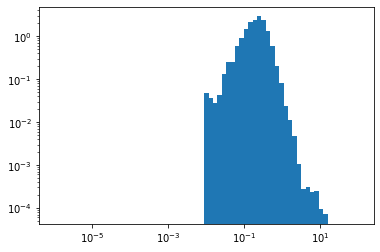

In [364]:
plt.hist(np.sqrt(nord_m**2+east_m**2+(up_m/4)**2), density=True,bins=np.logspace(-6,2,70))
plt.yscale('log')
plt.xscale('log')
plt.show()

In [316]:
coefs = moving_lin_regress(input, 9, 0, len(input))

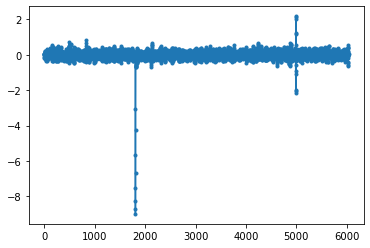

In [318]:
plt.plot(coefs,marker='.')